In [ ]:
!pip install tsfresh

# ИМПОРТ

In [ ]:
import tsfresh
from tsfresh import extract_features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras import utils
from keras import Model
from keras import Input
from keras.optimizer_v2.adam import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import MeanAbsolutePercentageError
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.np_utils import to_categorical   

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from IPython.display import clear_output 

# Stats model to perfrom statistical analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# To build ML models
from fbprophet import Prophet
from matplotlib import pyplot as plt
import pandas.util.testing as tm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

Mounted at /content/drive


# ДАННЫЕ

In [ ]:
DATASET = 0  # 0 - google_cluter, 1 - electricity, 2 - air_passengers, 3 - huawei, 4 - temperature, 5 - sunspots, -1 - debug, 

##__ Загрузка

###------------ функции

In [ ]:
def get_datetime_from_unix(time_column_unix):
    time_column_unix = df['time']
    time_column_datetime = []

    for i, x in enumerate(time_column_unix):
        time_column_datetime.append( datetime.fromtimestamp(x) )

    return np.array(time_column_datetime)

###------------ реализация

In [ ]:
if DATASET == -1:
    LEN = 99
    col_1 = np.arange(LEN)
    col_2 = np.arange(100, 100 + LEN)
    data = np.stack((col_1, col_2), axis=1)
    df = pd.DataFrame(data, columns = ["y0", "y1"])

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0


if DATASET == 0:
    USE_SPLIT = 'sixty'
    df = pd.read_csv(f'/content/drive/MyDrive/google_cluster_traces/{USE_SPLIT}_minute_sums.csv')
    df = df.rename(columns = {'0':'time'})
    df = df.rename(columns = {'cpu':'value'})
    df[['time']] = df[['time']] + 21738240 *60  # добавили разницу между 1970 и созданием trace     
    df['time'] = get_datetime_from_unix(df['time'])
    df.drop(columns=['ram'], inplace=True)
    data = df['value']
    data = np.expand_dims(data, axis=1)

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0


if DATASET == 1:
    path = '/content/drive/MyDrive/datasets/GefCom2012/Load_history.csv'
    df = pd.read_csv(path, decimal=',')

    df = (df[df.zone_id == 5]
        .dropna()
        .drop(columns=['zone_id']))

    df = pd.wide_to_long(df, stubnames='h', i=['year', 'month', 'day'], j='hour')
    df = df.rename(columns={'h':'value'})

    df = df.reset_index()
    df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df.drop(columns=['year', 'month', 'day', 'hour'])
    df = df[['time', 'value']]

    data = df['value']
    data = np.expand_dims(data, axis=1)

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0


if DATASET == 2:
    path = 'https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv'
    df = pd.read_csv(path)
    df.columns = ["time", "value"]
    data = df['value']
    data = np.expand_dims(data, axis=1)

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0


if DATASET == 3:
    path = '/content/drive/MyDrive/preparedData_southeast.csv'
    df = pd.read_csv(path, sep=';', decimal=',')
    df = df.iloc[200:]
    df = df.reset_index()
    df = df.drop(columns=['period', 'index'])

    strDates = df.date
    datetime_list = []
    for strDate in strDates:
        datetime_obj = datetime.strptime(strDate, "%Y-%m-%dT%H:%M:%S.000Z")
        datetime_list.append(datetime_obj)
    df.date = datetime_list

    df = df.rename(columns={"date":"time", df.columns[1 + 24]:'value'})
    df = df[['time', 'value']]
    data = df.value
    data = np.expand_dims(data, axis=1)

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0


if DATASET == 4:
    path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
    df = pd.read_csv(path)

    df = df.rename(columns={df.columns[0]:"time", df.columns[1]:"value"})
    data = df.value
    data = np.expand_dims(data, axis=1)

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0
    

if DATASET == 5:
    path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
    df = pd.read_csv(path)

    df = df.rename(columns={df.columns[0]:"time", df.columns[1]:"value"})
    data = df.value
    data = np.expand_dims(data, axis=1)

    VAL_SIZE = 0.15
    XLEN = 14
    LAG = 4
    PRED_CHANNEL = 0

##__Обработка

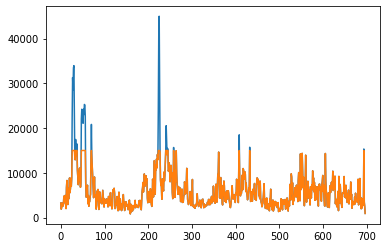

In [ ]:
if DATASET == 0:

    UP = 15000

    smoothed = np.empty(data.shape)
    for i in range(data.shape[0]):
        if data[i, 0] > UP:
            smoothed[i] = UP
        else:
            smoothed[i] = data[i]

    plt.plot(data)
    plt.plot(smoothed)
    plt.show
    
    data = smoothed
    df['value'] = smoothed

##__ Создание выборок

###------------ функции

In [ ]:
def create_train_val(data):

    # Извлекаем нужный канал и разбиваем на выборки
    train_raw, val_raw = train_test_split(data, test_size=VAL_SIZE, shuffle=False)

    x_train_raw = train_raw
    y_train_raw = train_raw[:, PRED_CHANNEL]
    y_train_raw = np.expand_dims(y_train_raw, axis=1)

    x_val_raw = val_raw
    y_val_raw = val_raw[:, PRED_CHANNEL]
    y_val_raw = np.expand_dims(y_val_raw, axis=1)


    # Разбиваем по timestep-ам
    x_train = np.array([   x_train_raw[ i:(i + (XLEN-1)) +1  , :]   for i in range(x_train_raw.shape[0] - (XLEN-1) - LAG)   ])
    y_train = np.array([   y_train_raw[    i + (XLEN-1) + LAG, :]   for i in range(x_train_raw.shape[0] - (XLEN-1) - LAG)   ])

    x_val =   np.array([     x_val_raw[ i:(i + (XLEN-1)) +1  , :]   for i in range(x_val_raw.shape[0]   - (XLEN-1) - LAG)   ])
    y_val =   np.array([     y_val_raw[    i + (XLEN-1) + LAG, :]   for i in range(x_val_raw.shape[0]   - (XLEN-1) - LAG)   ])


    # Нормализация (3D)
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    if DATASET != -1:
        x_train = x_scaler.fit_transform( x_train.reshape(x_train.shape[0], -1) ).reshape(x_train.shape)
        y_train = y_scaler.fit_transform( y_train.reshape(y_train.shape[0], -1) ).reshape(y_train.shape)

        x_val = x_scaler.transform(x_val.reshape(x_val.shape[0], -1)).reshape(x_val.shape)
        y_val = y_scaler.transform(y_val.reshape(y_val.shape[0], -1)).reshape(y_val.shape)


    return (x_train, y_train), (x_val, y_val), (x_scaler, y_scaler) 

###------------ реализация

In [ ]:
(x_train, y_train), (x_val, y_val), (x_scaler, y_scaler) = create_train_val(data)

###------------ графики

In [ ]:
# # Debug
# plt.plot( x_train[:, -1, 0] + LAG, y_train )
# plt.plot(   x_val[:, -1, 0] + LAG,   y_val )
# plt.grid()
# plt.show()

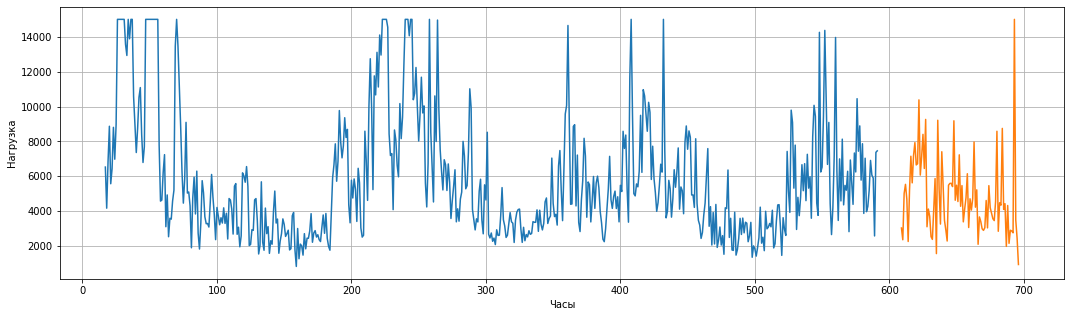

In [ ]:
x_train_indexes = np.arange((XLEN-1) + LAG, 
                            (XLEN-1) + LAG + x_train.shape[0])

x_val_indexes =   np.arange((XLEN-1) + LAG + x_train.shape[0] + (XLEN-1) + LAG, 
                            (XLEN-1) + LAG + x_train.shape[0] + (XLEN-1) + LAG + x_val.shape[0])

plt.figure(figsize=(18,5))
plt.plot(x_train_indexes,    y_scaler.inverse_transform(y_train))
plt.plot(x_val_indexes,      y_scaler.inverse_transform(y_val))
plt.ylabel('Нагрузка')
plt.xlabel('Часы')
plt.grid()
plt.show()

In [ ]:
df['time']

0     2011-05-02 00:00:00
1     2011-05-02 00:01:00
2     2011-05-02 00:02:00
3     2011-05-02 00:03:00
4     2011-05-02 00:04:00
              ...        
692   2011-05-02 11:32:00
693   2011-05-02 11:33:00
694   2011-05-02 11:34:00
695   2011-05-02 11:35:00
696   2011-05-02 11:36:00
Name: time, Length: 697, dtype: datetime64[ns]

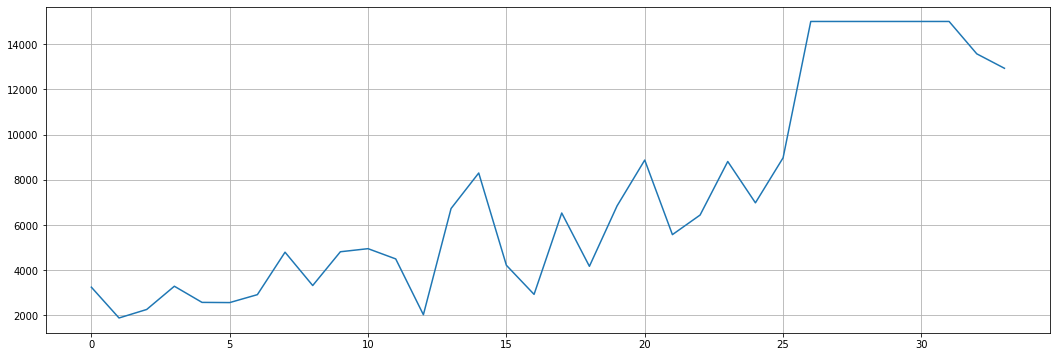

In [ ]:
START_PART = 0.0
LENGTH_PART = 0.05

start = int(data.shape[0] * START_PART)
length = int(data.shape[0] * LENGTH_PART)

plt.figure(figsize=(18,6))
plt.plot(np.arange(start, start + length), data[start:start + length])
plt.grid()
plt.show()

# МОДЕЛИ ГОТОВЫЕ

##__ Объявление списка экспертов

###------------ функции

In [ ]:
def naive_model_predict(X):

    return X[:,-1]

###------------ реализация

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

In [ ]:
other_models_count = 1

# МОДЕЛИ ОБУЧАЕМЫЕ

In [ ]:
T1_EPOCHS = 300
T1_ES_PATIENCE = T1_EPOCHS // 2
T1_lr = 1e-3
T1_bs = 32
LOSS = 'mae'

##__ Объявление списка экспертов

###------------ функции

In [ ]:
def create_lstm_model(name,
                          input_shape=(XLEN, data.shape[1]),
                          
                          L1_units=16,          L2_units=32,            L3_units=0,
                          L1_activation='relu', L2_activation='relu',   L3_activation='relu',
                          L1_dropout=0.1,       L2_dropout=0.1,         L3_dropout=0.1,

                          D1_neurons=64,        D2_neurons=0,
                          D1_activation='relu', D2_activation='relu',
                          D1_dropout=0.3,       D2_dropout=0.2,
                          
                          output_activation='relu'):
    model = Sequential(name=name)

    model.add(LSTM(L1_units, activation=L1_activation, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(L1_dropout))

    if L2_units > 0:
        model.add(LSTM(L2_units, activation=L2_activation, return_sequences=True))
        model.add(Dropout(L2_dropout))

    if L3_units > 0:
        model.add(LSTM(L3_units, activation=L3_activation, return_sequences=True))
        model.add(Dropout(L3_dropout))


    model.add(Flatten())


    if D1_neurons > 0:
        model.add(Dense(D1_neurons, activation=D1_activation))
        model.add(Dropout(D1_dropout))

    if D2_neurons > 0:
        model.add(Dense(D2_neurons, activation=D2_activation))
        model.add(Dropout(D2_dropout))


    model.add(Dense(1, activation=output_activation))

    return model

In [ ]:
def create_simple_model(name,
                          input_shape=(XLEN, data.shape[1]),
                        output_activation='relu'):

    model = Sequential(name=name)

    model.add(Flatten(input_shape=input_shape))

    model.add(Dense(1, activation=output_activation))

    return model

In [ ]:
def create_dense_model(name,
                        input_shape=(XLEN, data.shape[1]),
                          
                        D1_neurons=128,         D2_neurons=64,          D3_neurons=32,
                        D1_activation='relu',   D2_activation='relu',   D3_activation='relu',
                        D1_dropout=0.4,         D2_dropout=0.3,         D3_dropout=0.2,
                        
                        output_activation='relu'):

    model = Sequential(name=name)

    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(D1_neurons, activation=D1_activation))
    model.add(Dropout(D1_dropout))

    if D2_neurons > 0:
        model.add(Dense(D2_neurons, activation=D2_activation))
        model.add(Dropout(D2_dropout))
        
    if D3_neurons > 0:
        model.add(Dense(D3_neurons, activation=D3_activation))
        model.add(Dropout(D3_dropout))

    model.add(Dense(1, activation=output_activation))
    return model

In [ ]:
def create_conv_lstm_model(name,
                            input_shape=(XLEN, data.shape[1]),
                          
                            C1_filters=64,          C2_filters=128,
                            C1_kernel=3,            C2_kernel=3,
                            C1_strides=1,           C2_strides=1,
                            C1_dropout=0.0,         C2_dropout=0.0,
                            C1_poolSize=2,          C2_poolSize=2,

                            L1_units=16,            L2_units=32,            L3_units=0,
                            L1_activation='relu',   L2_activation='relu',   L3_activation='relu',
                            L1_dropout=0.1,         L2_dropout=0.1,         L3_dropout=0.1,

                            D1_neurons=64,          D2_neurons=0,
                            D1_activation='relu',   D2_activation='relu',
                            D1_dropout=0.3,         D2_dropout=0.2,
                            
                            output_activation='relu'):
    model = Sequential(name=name)

    # Conv
    model.add(Conv1D(C1_filters, C1_kernel, C1_strides, padding='causal', input_shape=input_shape))
    model.add(MaxPool1D(C1_poolSize))
    model.add(Dropout(C1_dropout))
    
    if C2_filters > 0:
        model.add(Conv1D(C2_filters, C2_kernel, C2_strides, padding='causal'))
        model.add(MaxPool1D(C2_poolSize))
        model.add(Dropout(C2_dropout))

    # LSTM
    if L1_units > 0:
        model.add(LSTM(L1_units, activation=L1_activation, return_sequences=True))
        model.add(Dropout(L1_dropout))

    if L2_units > 0:
        model.add(LSTM(L2_units, activation=L2_activation, return_sequences=True))
        model.add(Dropout(L2_dropout))

    if L3_units > 0:
        model.add(LSTM(L3_units, activation=L3_activation, return_sequences=True))
        model.add(Dropout(L3_dropout))

    # Out
    model.add(Flatten())
    model.add(Dense(1, activation=output_activation))
    return model

###------------ реализация

In [ ]:
models = []


models.append( create_simple_model('SLP') )

models.append( create_dense_model('MLP') )

models.append( create_dense_model('MLP-cut', D3_neurons=0) )

models.append( create_conv_lstm_model('Conv-LSTM') )

models.append( create_lstm_model('LSTM') )
models.append( create_lstm_model('LSTM-cut-l2_d1', L2_units=0, D1_neurons=0) )

models.append( create_lstm_model('LSTM-cut-l2', L2_units=0) )
models.append( create_lstm_model('LSTM-l3', L3_units=64) )
models.append( create_lstm_model('LSTM-d1', D1_neurons=128) )
models.append( create_lstm_model('LSTM-d2', D2_neurons=32) )

model = auto_arima(df_train.VWAP, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

##__ Обучение списка экспертов

###------------ функции

In [ ]:
def fit_models(models, loss='mse'):

    for model in models:

        fit_model(model, loss)

In [ ]:
def fit_model(model, loss='mse'):

    model.compile(loss=loss, optimizer=Adam(learning_rate=T1_lr))

    es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=T1_ES_PATIENCE)
    mcp_path1 = '/content/drive/MyDrive/some_model_weights_T1.mdl_wts.hdf5'
    mcp_save1 = ModelCheckpoint(mcp_path1, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
    callbacks = [es1, mcp_save1]

    history1 = model.fit(   x_train, y_train, 
                            batch_size=T1_bs, 
                            epochs=T1_EPOCHS, 
                            verbose=0,
                            validation_data=(x_val, y_val),
                            callbacks=callbacks)

    model.load_weights(mcp_path1)


    # Графики ошибок
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    print('\n', '\n', '\n', 'Yet another model:')
    plt.plot(np.log(loss))
    plt.plot(np.log(val_loss))
    plt.grid()
    plt.show()

###------------ реализация


 
 
 Yet another model:


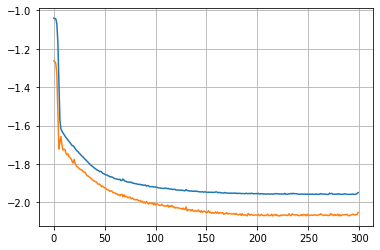


 
 
 Yet another model:


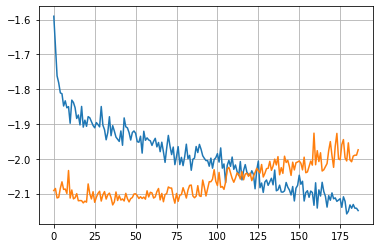


 
 
 Yet another model:


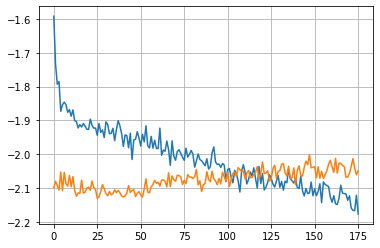


 
 
 Yet another model:


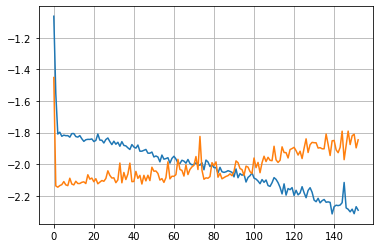


 
 
 Yet another model:


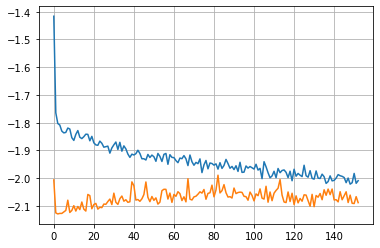


 
 
 Yet another model:


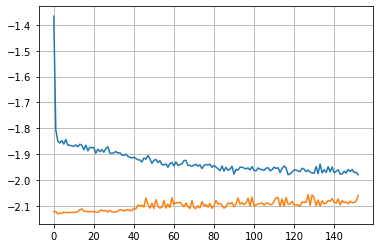


 
 
 Yet another model:


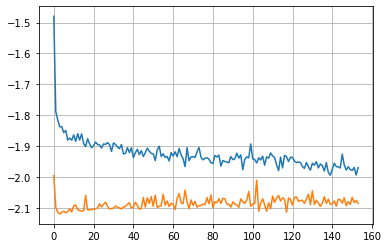


 
 
 Yet another model:


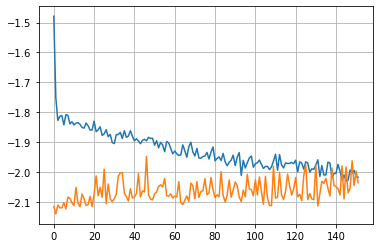


 
 
 Yet another model:


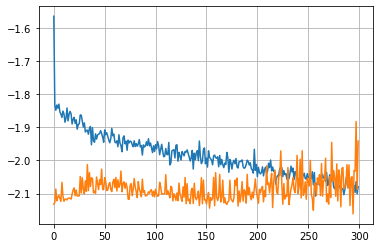


 
 
 Yet another model:


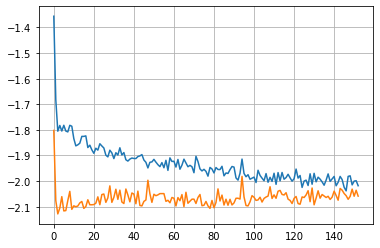

In [ ]:
fit_models(models, loss=LOSS)

###------------ графики

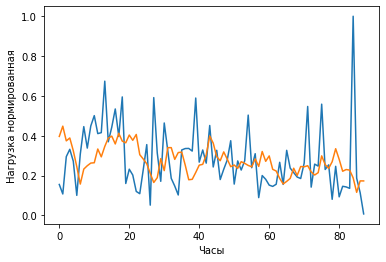

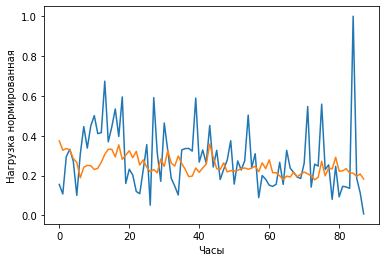

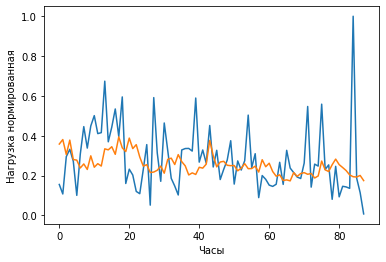

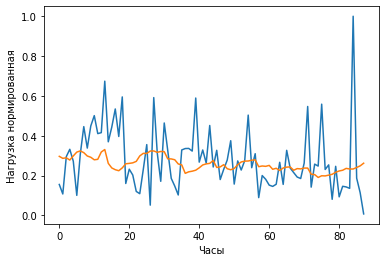

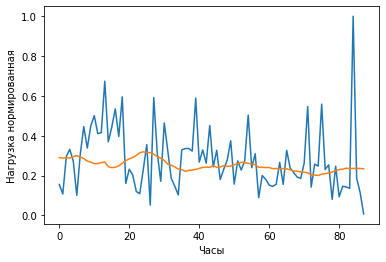

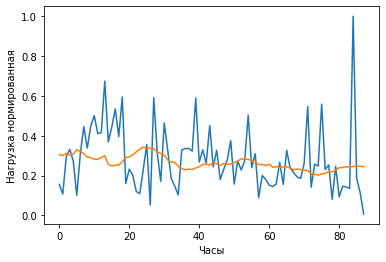

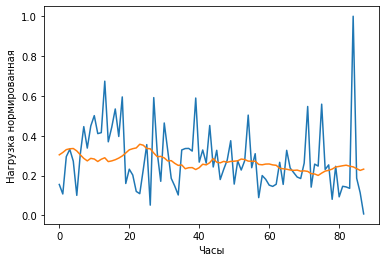

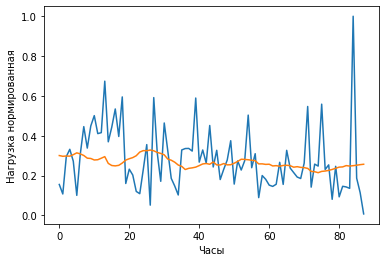

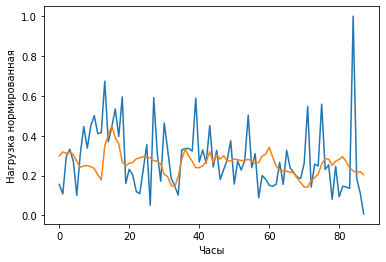

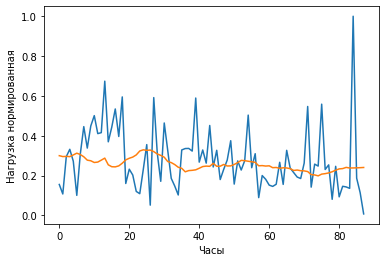

In [ ]:
for model in models:

    plt.plot(y_val)
    plt.plot(model.predict(x_val))
    plt.ylabel('Нагрузка нормированная')
    plt.xlabel('Часы')
    plt.show()

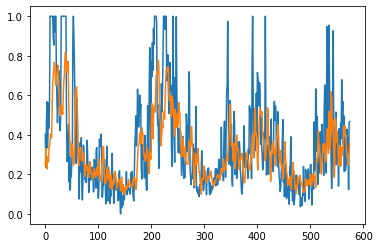

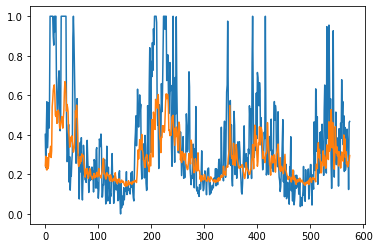

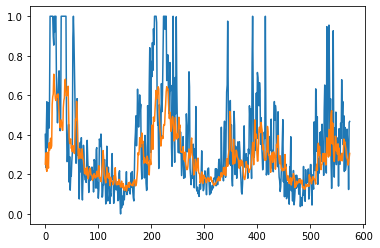

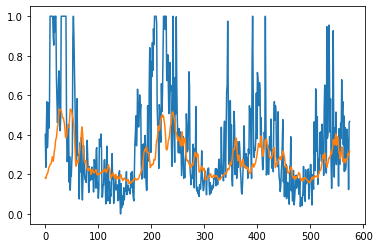

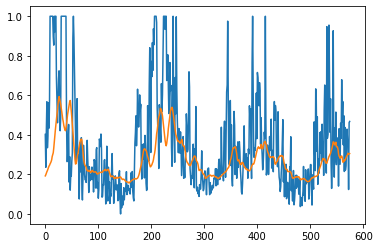

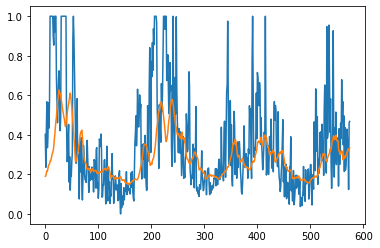

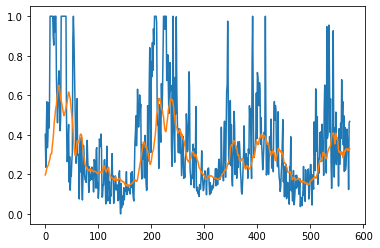

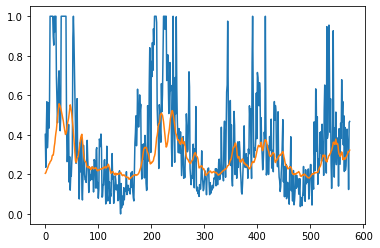

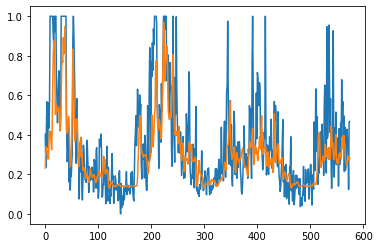

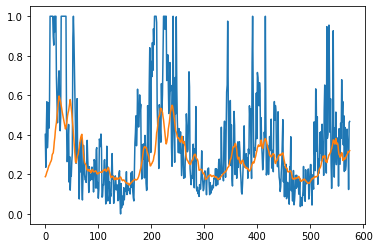

In [ ]:
for model in models:

    plt.plot(y_train)
    plt.plot(model.predict(x_train))
    plt.show()

# ИТЕРАЦИЯ ПО t

In [ ]:
START = 0.5  # не деать 0.0, потому что тогда история нулевая
END = 0.9
STEPS = 40

HIST_LEN = XLEN * 1  # учитывается агрегирующим алгоритмом
PRE_HIST_LEN = HIST_LEN + 1 * XLEN  # для подсчёта фич

PRIMARY_CORES_COUNT = 10
UNEXPECTED_CORES_COUNT = 5
PRIMARY_TO_UNEXPECTED_CORES_IMPORTANCE = 1

###------------ функции


In [ ]:
def create_x_y(data, pred_channels=PRED_CHANNEL, do_scaling=True):

    # Извлекаем нужный канал и разбиваем на выборки
    train_raw = data

    X_raw = train_raw
    Y_raw = train_raw[:, pred_channels]
    Y_raw = np.expand_dims(Y_raw, axis=1)

    # Разбиваем по timestep-ам
    X = np.array([   X_raw[ i:(i + (XLEN-1)) +1  , :]   for i in range(X_raw.shape[0] - (XLEN-1) - LAG)   ])
    Y = np.array([   Y_raw[    i + (XLEN-1) + LAG, :]   for i in range(X_raw.shape[0] - (XLEN-1) - LAG)   ])


    # Нормализация (3D)
    if (do_scaling and DATASET != -1):

        X_scaler = MinMaxScaler()
        Y_scaler = MinMaxScaler()

        X = X_scaler.fit_transform( X.reshape(X.shape[0], -1) ).reshape(X.shape)
        Y = Y_scaler.fit_transform( Y.reshape(Y.shape[0], -1) ).reshape(Y.shape)

        return (X, Y), (X_scaler, Y_scaler) 
    
    return X, Y 

In [ ]:
def hand_construct_features(data):

    def fill_array_to_size(arr, size):
        
        delta = size - arr.shape[0]

        fill_with = arr[0, :]

        res = np.full((size, arr.shape[1]), np.nan)
        
        res[delta: , :] = arr
        res[:delta, :] = fill_with
        
        return res

    d1 = data[1:] - data[:-1] 
    d1 = fill_array_to_size(d1, data.shape[0])

    d2 = d1[1:] - d1[:-1]
    d2 = fill_array_to_size(d2, data.shape[0])

    abs_d1 = np.abs(d1)
    abs_d2 = np.abs(d2)

    features = np.array([   d1,
                            d2,
                            abs_d1,
                            abs_d2])

    return features

In [ ]:
def tsFresh_construct_features(X_idx, df=df):

    features_parts = []

    for h in range(HIST_LEN):

        ts = df.iloc[X_idx[h].squeeze()]
        ts['id'] = np.full((X_idx.shape[1]), h, dtype=int)

        features_part_df = tsfresh.extract_features(ts, column_id='id', column_sort='time', column_value='value')
        clear_output()

        features_parts.append(features_part_df)

    features_df = pd.concat(features_parts)
    features_df.dropna(axis=1, inplace=True)
    
    feature_names = features_df.columns

    features = features_df.values.T
    features = np.expand_dims(features, axis=2)

    
    return features, feature_names

In [ ]:
def tsFresh_construct_features_v2(X_idx, df=df):

    ts = df.iloc[X_idx.flatten()]
    
    ts['id'] = np.array([[i]*XLEN  for i in range(X_idx.shape[0])]).flatten()
    features_df = tsfresh.extract_features(ts, column_id='id', column_sort='time', column_value='value')
    
    # clear_output()
    features_df.dropna(axis=1, inplace=True)
    
    feature_names = features_df.columns

    features = features_df.values.T
    features = np.expand_dims(features, axis=2)

    
    return features, feature_names

In [ ]:
def construct_cores_history(features, feature_names):

    # Убрать inf
    features[np.isinf(features)] = 1e16

    wide_cores = []
    core_names = []

    for k, feature in enumerate(features):

        def get_special_std(feature):

            scaler = StandardScaler()
            feature_std_inf_inf = scaler.fit_transform( feature )
            feature_std_3_3 = np.clip(feature_std_inf_inf, -3, 3)
            feature_std_0_1 = (feature_std_3_3 + 3) /6

            return feature_std_0_1

        if np.unique(feature).size == 1:

            continue

        if np.array_equal( np.unique(feature) , np.array([0,1]) ):

            wide_cores.append(feature)
            core_names.append(feature_names[k])
            continue

        if np.any(feature < 0):

            feature_pos = np.multiply(feature, [feature >= 0])[0]
            feature_neg = np.multiply(feature, [feature <= 0])[0]

            wide_cores.append( get_special_std(feature_pos) )
            wide_cores.append( get_special_std(feature_neg) )
            core_names.append(feature_names[k] + '_pos')
            core_names.append(feature_names[k] + '_neg')
            continue
            
        if not np.any(np.logical_or(feature < 0, feature > 1)):

            wide_cores.append(feature)
            core_names.append(feature_names[k])
            continue


        else:

            wide_cores.append( get_special_std(feature) )
            core_names.append(feature_names[k])


    return np.array(wide_cores), np.array(core_names)

In [ ]:
def get_losses_history(models, X, Y):

    losses_history = []
    APE_history = []
    model_names = []


    # Для не-керасовских моделей
    pred = naive_model_predict(X)
    model_loss = Y - pred

    model_abs_loss = np.abs(model_loss)
    model_APE = np.abs(model_loss / Y) *100

    losses_history.append(model_abs_loss)
    APE_history.append(model_APE)
    model_names.append('Naive')


    # Для керасовских моделей
    for model in models:

        pred = model.predict(X)
        model_loss = Y - pred

        model_abs_loss = np.abs(model_loss)
        model_APE = np.abs(model_loss / Y) *100

        losses_history.append(model_abs_loss)
        APE_history.append(model_APE)
        model_names.append(model.name)
        
    losses_history = np.array(losses_history)
    APE_history = np.array(APE_history)

    return losses_history, APE_history, model_names

In [ ]:
def getMultOf__cores_history__with__losses_history(cores_history, losses_history):

    cored_losses_history = np.zeros( (  cores_history.shape[0], 
                                        losses_history.shape[0], 
                                        losses_history.shape[1]) )

    for k, core in enumerate(cores_history):

        for i, loss in enumerate(losses_history):

            cored_losses_history[k, i, :] = core * loss
    
    return cored_losses_history

In [ ]:
def get_primary_cores_idx_and_importance(cores_history, losses_history, primary_cores_count=PRIMARY_CORES_COUNT):

    corr_coefs_means_list = []
    for core_history in cores_history:
        abs_corr_coefs = []
        for loss_history in losses_history:
            corr_matrix = np.corrcoef(core_history, loss_history)
            abs_corr_coef = np.absolute(corr_matrix[0,1])
            abs_corr_coefs.append(abs_corr_coef)                
        abs_corr_coefs = np.array(abs_corr_coefs)

        corr_coefs_mean = np.average(abs_corr_coefs)
        corr_coefs_means_list.append(corr_coefs_mean)
    corr_coefs_means = np.array(corr_coefs_means_list)

    corr_coefs_means_df = pd.DataFrame(corr_coefs_means, columns=['corr_mean'])
    corr_coefs_means_df_sorted = corr_coefs_means_df.sort_values('corr_mean', ascending=False)
    primary_cores_df = corr_coefs_means_df_sorted.iloc[:primary_cores_count]
    primary_cores_idx = np.array(primary_cores_df.index, dtype=int)
    primary_cores_importance = primary_cores_df.values / np.max(primary_cores_df.values)

    return primary_cores_idx, primary_cores_importance

In [ ]:
def get_unexpected_cores_idx_and_importance(model_MAEs, cored_model_MAEs, unexpected_cores_count=UNEXPECTED_CORES_COUNT):

    best_model_idx = np.argmin(model_MAEs)

    diff_percents = []
    for k in range(cored_model_MAEs.shape[0]):
        expectedBest_model_MAE = cored_model_MAEs[k, best_model_idx]
        best_model_MAE = np.min(cored_model_MAEs[k, :])

        diff_percent = (expectedBest_model_MAE - best_model_MAE) / expectedBest_model_MAE *100
        diff_percents.append(diff_percent)
    diff_percents = np.array(diff_percents)

    diff_percents_df = pd.DataFrame(diff_percents, columns=['diff_p'])
    diff_percents_df_sorted = diff_percents_df.sort_values('diff_p', ascending=False)
    unexpected_cores_df = diff_percents_df_sorted.iloc[:unexpected_cores_count]
    unexpected_cores_idx = np.array(unexpected_cores_df.index, dtype=int)
    unexpected_cores_importance = unexpected_cores_df.values / np.max(unexpected_cores_df.values)

    return unexpected_cores_idx, unexpected_cores_importance

In [ ]:
# Назначение весов
def recipSquare_weights_from_losses(losses):

    points = np.reciprocal(losses)
    points = points*points
    weights = points / np.sum(points)

    return weights
def recipLinear_weights_from_losses(losses):

    points = np.reciprocal(losses)
    weights = points / np.sum(points)

    return weights
def bestOne_weights_from_losses(losses):
    
    best_idx = np.argmin(losses)
    weights = to_categorical(best_idx, num_classes=losses.size)

    return weights

In [ ]:
def get_cored_loss(cores, useful_incompetence_matrix):

    cored_loss = np.matmul(useful_incompetence_matrix.T, cores.reshape(-1, 1))
    cored_loss = cored_loss.squeeze()

    return cored_loss

###------------ реализация

In [ ]:
# Берём val и обозначаем точки для изучения
_, val_raw =        train_test_split(data,                                   test_size=VAL_SIZE, shuffle=False)
_, val_raw_idx =    train_test_split(np.arange(data.shape[0]).reshape(-1,1), test_size=VAL_SIZE, shuffle=False)
t_arr = np.linspace(int(val_raw.shape[0] * START), 
                    int(val_raw.shape[0] * END), 
                    STEPS,
                    dtype=int)



# Всякое
AAs_COUNT = 4
CORE_GROUPS_COUNT = 2

keras_models_count = len(models)
models_count = other_models_count + keras_models_count
timesteps_count = val_raw.shape[0]

AAs_weights_history = np.full((AAs_COUNT, models_count, timesteps_count), np.nan)
AAs_forecasts_history = np.full((AAs_COUNT, timesteps_count), np.nan)
model_MAEs_history = np.full((models_count, timesteps_count), np.nan)
model_MAPEs_history = np.full((models_count, timesteps_count), np.nan)

core_groups_history = np.full((CORE_GROUPS_COUNT + 1, timesteps_count), np.nan)



# Пошла-поехала итерация
for t_idx, t in enumerate(t_arr):


    clear_output()
    print(f'ts {t_idx+1}/{len(t_arr)}')



    # Отрезали кусок [t-PRE_HIST_LEN; t]
    if (t - PRE_HIST_LEN) +1 >= 0:
        pre_hist_data =    val_raw[(t - PRE_HIST_LEN) +1:t +1]
        pre_hist_idx = val_raw_idx[(t - PRE_HIST_LEN) +1:t +1]
    else:
        print('ERROR: t is too low')



    # X, Y
    (x_agr_wide, y_agr_wide), (x_agr_scaler, y_agr_scaler) = create_x_y(pre_hist_data)
    (x_idx_wide, y_idx_wide)                               = create_x_y(pre_hist_idx, do_scaling=False)

    x_agr = x_agr_wide[-HIST_LEN:]
    y_agr = y_agr_wide[-HIST_LEN:]

    x_idx = x_idx_wide[-HIST_LEN:]
    y_idx = y_idx_wide[-HIST_LEN:]



    # Получили особеннности
    features, feature_names = tsFresh_construct_features_v2(x_idx)    
    cores_history, core_names = construct_cores_history(features, feature_names)
    cores_history = np.squeeze(cores_history)


    # Получили историю ошибок_моделей
    losses_history, APE_history, model_names = get_losses_history(models, x_agr, y_agr)
    losses_history = np.squeeze(losses_history)
    APE_history = np.squeeze(APE_history)


    # Получили историю ошибок_моделе в особенностях 
    cored_losses_history = getMultOf__cores_history__with__losses_history(cores_history, losses_history)


    # Получили итоги(среднее) по истории
    incompetence_matrix = np.mean(cored_losses_history, axis=2)
    model_MAEs = np.mean(losses_history, axis=1)
    model_MAPEs = np.mean(APE_history, axis=1)


    # Некомпетентность
    incompetence_matrix_df = pd.DataFrame(  incompetence_matrix,
                                            columns=model_names,
                                            index=core_names)



    # Первостепенные cores
    #  - которые хорошо коррелировали с историей ошибок экспертов
    primary_cores_idx, primary_cores_importance = get_primary_cores_idx_and_importance(cores_history, losses_history)
    primary_cores_importance *= PRIMARY_TO_UNEXPECTED_CORES_IMPORTANCE
    primary_incompetence_matrix = incompetence_matrix[primary_cores_idx, :]
    primary_cores_history = cores_history[primary_cores_idx]
    primary_core_names = core_names[primary_cores_idx]


    # Неожиданные cores
    #  - в которых некоторые эксперты были лучше лучшего эксперта
    unexpected_cores_idx, unexpected_cores_importance = get_unexpected_cores_idx_and_importance(model_MAEs, incompetence_matrix)


    # Объединили в полезные cores
    #  - первостепенные + неожиданные cores
    core_groups_history[0, t] = cores_history.shape[0]
    core_groups_history[1, t] = primary_cores_idx.size
    core_groups_history[2, t] = unexpected_cores_idx.size

    useful_cores_idx =          np.concatenate([primary_cores_idx, unexpected_cores_idx])
    useful_cores_importance =   np.concatenate([primary_cores_importance, unexpected_cores_importance])

    useful_incompetence_matrix_df = incompetence_matrix_df.iloc[useful_cores_idx, :]
    useful_incompetence_matrix = incompetence_matrix[useful_cores_idx, :]

    useful_cores_history = cores_history[useful_cores_idx]
    useful_core_names = core_names[useful_cores_idx]

    print(f'primary: {primary_cores_idx.size}  unexpected: {unexpected_cores_idx.size}')



    # Способы получения loss-а
    naiveAA_losses = losses_history[:, -1]

    single_cores = useful_cores_history[:, -1]
    # coresAA_losses = get_cored_loss(single_cores, useful_incompetence_matrix)

    single_cores_importance_mul = single_cores * useful_cores_importance.squeeze()
    coresImportanceAA_losses = get_cored_loss(single_cores_importance_mul, useful_incompetence_matrix)


    # Список весов разных АА
    AAs_weights_list = []
    AAs_name_list = []

    naiveAA_weights =   recipLinear_weights_from_losses(naiveAA_losses)
    naiveBestAA_weights =   bestOne_weights_from_losses(naiveAA_losses)
    coresAA_weights =    recipLinear_weights_from_losses(coresImportanceAA_losses)
    coresBestAA_weights =    bestOne_weights_from_losses(coresImportanceAA_losses)
    
    AAs_weights_list.append(naiveAA_weights)
    AAs_weights_list.append(naiveBestAA_weights)
    AAs_weights_list.append(coresAA_weights)
    AAs_weights_list.append(coresBestAA_weights)

    AAs_name_list.append('Ансамбль наивный')
    AAs_name_list.append('Ансамбль наивный (один эксперт)')
    AAs_name_list.append('Ансамбль предлагаемый')
    AAs_name_list.append('Ансамбль предлагаемый (один эксперт)')

    AAs_weights = np.array(AAs_weights_list)
    AAs_names = np.array(AAs_name_list)



    # Прогнозы моделей..
    model_preds = []
                    #..прочих
    pred = naive_model_predict(pre_hist_data[-XLEN:].reshape(1, -1, 1))
    model_preds.append(pred)

                    #..кераса
    for model in models:
        pred = model.predict(pre_hist_data[-XLEN:].reshape(1, -1, 1))
        model_preds.append(pred)
    model_preds = np.array(model_preds)
    model_preds = model_preds.squeeze()



    # Прогнозы ансамблей
    AAs_forecasts = np.sum(AAs_weights * model_preds, axis=1)



    # Сохраняем в историю    
    AAs_weights_history[:, :, t] = AAs_weights
    AAs_forecasts_history[:, t] = AAs_forecasts
    model_MAEs_history[:, t] = model_MAEs
    model_MAPEs_history[:, t] = model_MAPEs

ts 40/40


Feature Extraction: 100%|██████████| 11/11 [00:00<00:00, 14.97it/s]


primary: 10  unexpected: 5


In [ ]:
# Выбрали нужные t
AAs_weights_hist = AAs_weights_history[:, :, t_arr]
AAs_forecasts_hist = AAs_forecasts_history[:, t_arr]
model_MAEs_hist = model_MAEs_history[:, t_arr]
model_MAPEs_hist = model_MAPEs_history[:, t_arr]


# Получили loss-ы
true = val_raw[ t_arr + LAG ].T
AAs_losses_hist = true - AAs_forecasts_hist

AAs_MAEs =  np.mean(np.absolute(AAs_losses_hist), axis=1) 
AAs_MAPEs = np.mean(np.absolute(AAs_losses_hist / true *100), axis=1) 
model_MAEs_mean =   np.mean(model_MAEs_hist, axis=1)
model_MAPEs_mean =  np.mean(model_MAPEs_hist, axis=1)

In [ ]:
AAs_forecasts_hist

array([[4.39460862e+03, 2.77105872e+03, 2.97656438e+03, 2.44297965e+03,
        3.58162699e+03, 4.02356994e+03, 4.08904425e+03, 1.68748860e+03,
        3.54474569e+03, 4.37585371e+03, 2.29972434e+03, 2.82143040e+03,
        2.31592510e+03, 3.27492571e+03,            nan, 2.50522828e+03,
        3.72444498e+03, 2.38518880e+03, 3.62905626e+03, 2.62475271e+03,
        3.30703919e+03, 2.52683447e+03, 2.37966510e+03, 2.99959945e+03,
        2.53244138e+03, 2.41723846e+03, 2.12587163e+03, 2.44857441e+03,
        2.57410083e+03, 2.09848625e+03, 2.66604174e+03, 4.83527059e+03,
        1.66277873e+03, 3.50954841e+03, 3.05049641e+03, 1.93875857e+03,
        2.69337083e+03, 4.45151416e+02,            nan, 2.94965227e+03],
       [5.49065706e+03, 2.84686597e+03, 8.20253119e-02, 3.25113574e+03,
        9.18316332e+03, 4.96314990e+03, 5.48927355e+03, 1.39501065e-01,
        4.34170508e+03, 1.35619326e+04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.20253119e-02, 3.06354747e+03, 1.28227

###------------ графики

MAE

In [ ]:
# Создание df для визуализации
AAs_MAEs_df = pd.DataFrame( AAs_MAEs, 
                            index=AAs_names,
                            columns=['MAE'])

model_MAEs_mean_unscaled = y_scaler.inverse_transform(model_MAEs_mean.reshape(-1,1))
model_MAEs_mean_df = pd.DataFrame(  model_MAEs_mean_unscaled,
                                    index = model_names,
                                    columns = ['MAE'])

final_MAE_df = model_MAEs_mean_df.append(AAs_MAEs_df)
final_MAE_df.sort_values('MAE', ascending=True, inplace=True)
final_MAE_df

,MAE
Ансамбль предлагаемый,1923.684943
Ансамбль наивный (один эксперт),2989.847992
Ансамбль предлагаемый (один эксперт),3692.670096
LSTM-cut-l2_d1,3869.702837
LSTM-l3,3888.866653
LSTM,3893.116468
LSTM-d2,3901.367570
Conv-LSTM,3910.258480
LSTM-cut-l2,3914.416575
LSTM-d1,4012.465537


MAPE

In [ ]:
# Создание df для визуализации
AAs_MAPEs_df = pd.DataFrame(AAs_MAPEs, 
                            index=AAs_names,
                            columns=['MAPE'])

model_MAPEs_df = pd.DataFrame(  model_MAPEs_mean,
                                index = model_names,
                                columns = ['MAPE'])

final_MAPE_df = model_MAPEs_df.append(AAs_MAPEs_df)
final_MAPE_df.sort_values('MAPE', ascending=True, inplace=True)
final_MAPE_df

,MAPE
Ансамбль предлагаемый,36.362157
Ансамбль наивный (один эксперт),71.114311
Ансамбль предлагаемый (один эксперт),82.074552
SLP,inf
MLP,inf
MLP-cut,inf
Conv-LSTM,inf
LSTM,inf
LSTM-cut-l2_d1,inf
LSTM-cut-l2,inf


По выбранному t

In [ ]:
t = t_arr[2]

naiveAA_forecast = AAs_forecasts_history[0, t]
charAA_forecast = AAs_forecasts_history[1, t]

true = val_raw[t + LAG, 0]

naiveAA_loss = true - naiveAA_forecast
charAA_loss = true - charAA_forecast


forecast_df = pd.DataFrame( [true, naiveAA_forecast, charAA_forecast], 
                            index=['true', 'naive', 'autocorr'],
                            columns=['forecast'])

loss_df = pd.DataFrame( [0, naiveAA_loss, charAA_loss], 
                        index=['true', 'naive', 'autocorr'],
                        columns=['loss'])


# Merge all DataFrames into one
from functools import reduce

dfs = [forecast_df, loss_df]
final_df = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True, how='outer'), dfs)
final_df

,forecast,loss
true,5489.273549,0.000000
naive,2976.564378,2512.709171
autocorr,0.082025,5489.191523


История всякая

In [ ]:
core_groups_history_df = pd.DataFrame(core_groups_history,
                                      index=['всего', '1 группа', '2 группа'],
                                      dtype=int)
core_groups_log_df = core_groups_history_df.dropna(axis=1)
core_groups_log_df.transpose()

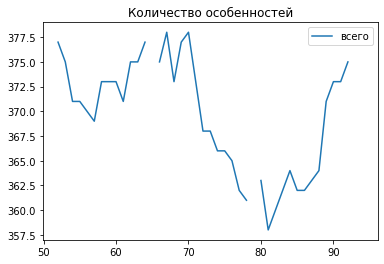

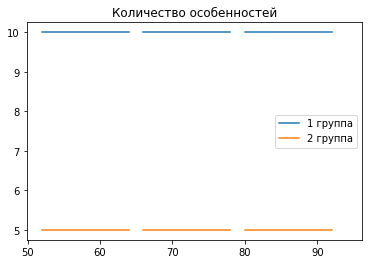

In [ ]:
plt.plot(core_groups_history[0])
plt.legend(['всего'])
plt.title('Количество особенностей')
plt.show()

plt.plot(core_groups_history[1])
plt.plot(core_groups_history[2])
plt.legend(['1 группа', '2 группа'])
plt.title('Количество особенностей')
plt.show(ьшенф_дщр)